<a href="https://colab.research.google.com/github/flohmannjr/TCC530/blob/main/TCC530_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC530 - Modelos

## Importações de bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Bidirectional, Concatenate, Conv1D, Dense
from tensorflow.keras.layers import Dropout, GlobalMaxPool1D, GRU, Input, LSTM

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

## Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

sns.set_style("darkgrid")

### Constantes

In [3]:
SEMENTE = 2008193

LIMITE_DICIONARIO = 80000

MAXIMO_MODELOS = 20

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'sigmoid'

ESPACO_SAIDA = 50
NUCLEO_TAMANHO = 64
PREENCHIMENTO = 'same'

ABANDONOS = 0.1

PERDA = 'binary_crossentropy'
APRENDIZADO = 0.001
METRICAS = ['accuracy']

ITERACOES = 5

## Dados

Fake.Br Corpus https://github.com/roneysco/Fake.br-Corpus

In [4]:
dados = pd.read_csv('https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv',
                    index_col=['index'])

In [5]:
dados['label'].replace({'fake': 0, 'true': 1}, inplace=True)

In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 0 to 7199
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              7200 non-null   int64 
 1   preprocessed_news  7200 non-null   object
dtypes: int64(1), object(1)
memory usage: 168.8+ KB


In [7]:
dados

,label,preprocessed_news
index,,
0,0,katia abreu diz vai colocar expulsao moldura n...
1,0,ray peita bolsonaro conservador fake entrevist...
2,0,reinaldo azevedo desmascarado policia federal ...
3,0,relatorio assustador bndes mostra dinheiro pub...
4,0,radialista americano fala sobre pt vendem ilus...
...,...,...
7195,1,jornal britanico acao contra lula lava jato se...
7196,1,temer diz acionou pf cade investigar aumentos ...
7197,1,obstaculos politicos temer especialistas ouvid...


In [8]:
dados['label'].value_counts()

0    3600
1    3600
Name: label, dtype: int64

In [9]:
X = dados['preprocessed_news']
y = dados['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEMENTE)

In [10]:
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [11]:
# X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype

### Converter texto em números

In [12]:
# media_palavras_por_texto = round(sum([len(texto.split()) for texto in X_train]) / len(X_train))
maximo_palavras_por_texto = max([len(texto.split()) for texto in X_train])

# tamanho_texto = media_palavras_por_texto
tamanho_texto = maximo_palavras_por_texto

#### Vetorização (Vectorization)

In [13]:
vetorizador = TextVectorization(max_tokens=LIMITE_DICIONARIO,               # (Default: None) Máximo de tokens (palavras) no dicionário.
                                standardize='lower_and_strip_punctuation',  # (Default) Texto em caixa baixa e retira caracteres especiais.
                                split='whitespace',                         # (Default) Separador de tokens.
                                ngrams=None,                                # (Default) Tokens por grupo. (None = não agrupar tokens.)
                                output_mode='int',                          # (Default) Como mapear tokens para números.
                                output_sequence_length=tamanho_texto)       # (Default: None) Tamanho do texto, completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [14]:
vetorizador.adapt(X_train)

In [15]:
# texto = random.choice(X_train)
# print(texto)

# vet = vetorizador([texto])

In [16]:
# with np.printoptions(threshold=np.inf):
#     print(vet)

In [17]:
vocabulario = vetorizador.get_vocabulary()

In [18]:
# [UNK] = Desconhecido, fora do limite do dicionário.
len(vocabulario), vocabulario[:10], vocabulario[-10:]

(73258,
 ['',
  '[UNK]',
  'nao',
  'lula',
  'ser',
  'sao',
  'tambem',
  'presidente',
  'disse',
  'sobre'],
 ['abafem',
  'abafarem',
  'abafada',
  'abacc',
  'aas',
  'aapesar',
  'aachen',
  'aace',
  'aabertura',
  'aabb'])

#### Incorporação (Embedding)

In [19]:
incorporador = Embedding(input_dim=LIMITE_DICIONARIO,  # Tamanho do vocabulário de entrada.
                         output_dim=128,               # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=tamanho_texto)   # Tamanho do texto de entrada.

In [20]:
# texto = random.choice(X_train)
# print(texto)

# incorporador(vetorizador([texto]))

## Funções

In [21]:
def grafico_historico_por_iteracao(historico):

    for chave in historico.history.keys():
        sns.lineplot(data=historico.history[chave], label=chave)

    plt.title('Histórico por iteração')
    plt.xlabel('Iteração')
    plt.ylabel('')

    plt.legend(frameon=True, facecolor='white')
    plt.show()

def avaliar_modelo(validacao, previsao, rotulos=None, cmap='summer_r'):
    print(classification_report(validacao, previsao, target_names=rotulos))

    ConfusionMatrixDisplay.from_predictions(validacao, previsao, display_labels=rotulos, xticks_rotation='vertical', cmap=cmap)
    plt.grid(False)

    relatorio = classification_report(validacao, previsao, target_names=rotulos, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

def dados_modelo(indice):
    avaliacoes[indice] = modelos[indice].evaluate(X_test, y_test)
    probabilidades[indice] = modelos[indice].predict(X_test)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(y_test, previsoes[indice])

## Modelos

In [22]:
modelos = [None] * MAXIMO_MODELOS

avaliacoes     = [None] * MAXIMO_MODELOS
probabilidades = [None] * MAXIMO_MODELOS
previsoes      = [None] * MAXIMO_MODELOS
relatorios     = [None] * MAXIMO_MODELOS

historicos = [None] * MAXIMO_MODELOS

modelo_numero = 0

### Modelo 0: Naive Bayes com codificador TF-IDF (baseline)

In [23]:
modelo_nome = f'modelo_{modelo_numero}_naive_bayes'

modelos[modelo_numero] = Pipeline([('tdidf', TfidfVectorizer()),
                                   ('clf', MultinomialNB())]) # clf = classifier

modelos[modelo_numero].fit(X_train, y_train)

Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
previsoes[modelo_numero] = modelos[modelo_numero].predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.22      0.36       741
           1       0.55      1.00      0.71       699

    accuracy                           0.60      1440
   macro avg       0.77      0.61      0.53      1440
weighted avg       0.77      0.60      0.53      1440



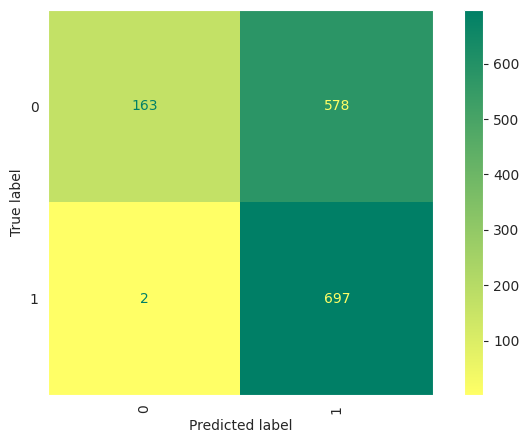

In [25]:
relatorios[modelo_numero] = avaliar_modelo(y_test, previsoes[modelo_numero])

In [26]:
relatorios[modelo_numero]

{'acuracia': 0.5972222222222222,
 'precisao': 0.7737070707070706,
 'revocacao': 0.5972222222222222,
 'pontuacao-f1': 0.5279508332382786}

### Camadas iniciais padronizadas

In [27]:
%%time

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas_iniciais = vetorizador(entradas)
camadas_iniciais = incorporador(camadas_iniciais)

CPU times: user 375 ms, sys: 2.76 ms, total: 378 ms
Wall time: 1.21 s


### Modelo 1: Denso

In [28]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_denso'

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 34s 329ms/step - loss: 0.6519 - accuracy: 0.5429 - val_loss: 0.6020 - val_accuracy: 0.7201
Epoch 2/5
90/90 [==============================] - 23s 260ms/step - loss: 0.5042 - accuracy: 0.8938 - val_loss: 0.4239 - val_accuracy: 0.9451
Epoch 3/5
90/90 [==============================] - 23s 255ms/step - loss: 0.3145 - accuracy: 0.9693 - val_loss: 0.2720 - val_accuracy: 0.9569
Epoch 4/5
90/90 [==============================] - 22s 244ms/step - loss: 0.1917 - accuracy: 0.9740 - val_loss: 0.1963 - val_accuracy: 0.9583
Epoch 5/5
90/90 [==============================] - 21s 235ms/step - loss: 0.1306 - accuracy: 0.9788 - val_loss: 0.1593 - val_accuracy: 0.9576
CPU times: user 1min 27s, sys: 1.92 s, total: 1min 29s
Wall time: 2min 24s


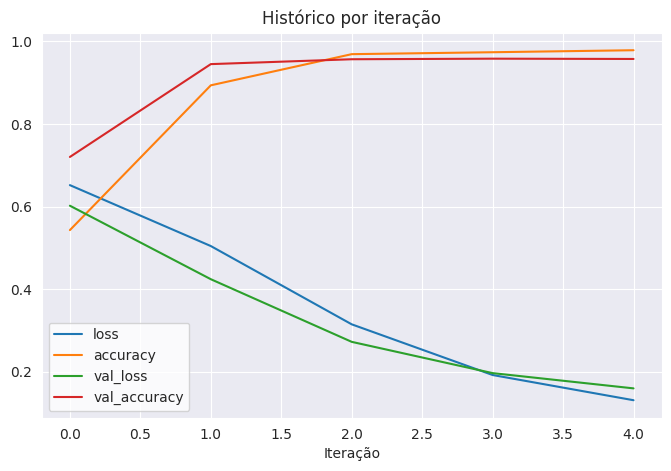

In [29]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       741
           1       0.95      0.96      0.96       699

    accuracy                           0.96      1440
   macro avg       0.96      0.96      0.96      1440
weighted avg       0.96      0.96      0.96      1440



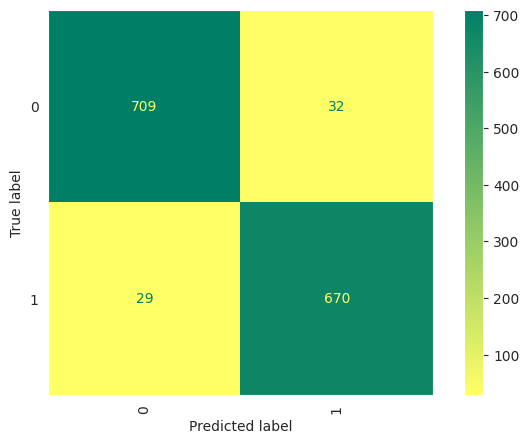

In [30]:
dados_modelo(modelo_numero)

In [31]:
relatorios[modelo_numero]

{'acuracia': 0.9576388888888889,
 'precisao': 0.9576519902485349,
 'revocacao': 0.9576388888888889,
 'pontuacao-f1': 0.9576412808102392}

### Modelo 2: LSTM

In [32]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_lstm'

# camadas = LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN, return_sequences=True)(camadas_iniciais) # Para empilhar camadas recorrentes é necessário return_sequences=True
# camadas = LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN)(camadas)
camadas = LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN)(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 37s 365ms/step - loss: 0.6937 - accuracy: 0.5092 - val_loss: 0.6943 - val_accuracy: 0.4854
Epoch 2/5
90/90 [==============================] - 32s 356ms/step - loss: 0.6947 - accuracy: 0.4934 - val_loss: 0.6927 - val_accuracy: 0.5146
Epoch 3/5
90/90 [==============================] - 31s 347ms/step - loss: 0.6939 - accuracy: 0.4984 - val_loss: 0.6966 - val_accuracy: 0.4854
Epoch 4/5
90/90 [==============================] - 33s 364ms/step - loss: 0.6935 - accuracy: 0.4970 - val_loss: 0.6929 - val_accuracy: 0.5146
Epoch 5/5
90/90 [==============================] - 31s 343ms/step - loss: 0.6933 - accuracy: 0.4998 - val_loss: 0.6928 - val_accuracy: 0.5146
CPU times: user 2min 17s, sys: 2.24 s, total: 2min 19s
Wall time: 3min 24s


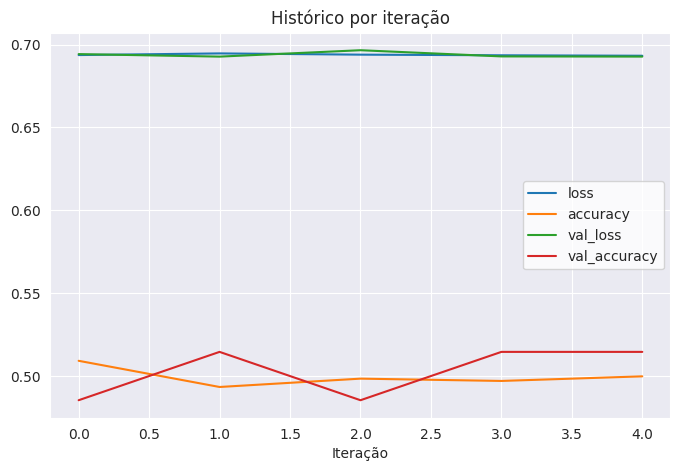

In [33]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 3s 48ms/step
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       741
           1       0.00      0.00      0.00       699

    accuracy                           0.51      1440
   macro avg       0.26      0.50      0.34      1440
weighted avg       0.26      0.51      0.35      1440



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

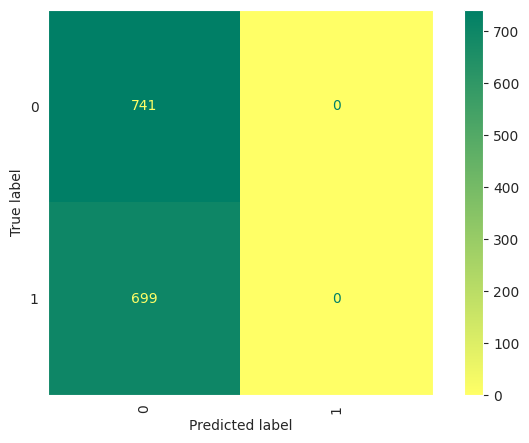

In [34]:
dados_modelo(modelo_numero)

In [35]:
relatorios[modelo_numero]

{'acuracia': 0.5145833333333333,
 'precisao': 0.26479600694444444,
 'revocacao': 0.5145833333333333,
 'pontuacao-f1': 0.34966185236130215}

### Modelo 3: GRU

In [36]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_gru'

# camadas = GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN, return_sequences=True)(camadas_iniciais)
# camadas = GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN)(camadas)
camadas = GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN)(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 35s 354ms/step - loss: 0.6946 - accuracy: 0.4955 - val_loss: 0.6953 - val_accuracy: 0.4854
Epoch 2/5
90/90 [==============================] - 31s 344ms/step - loss: 0.6944 - accuracy: 0.4929 - val_loss: 0.6928 - val_accuracy: 0.5146
Epoch 3/5
90/90 [==============================] - 32s 356ms/step - loss: 0.6946 - accuracy: 0.4943 - val_loss: 0.6963 - val_accuracy: 0.4854
Epoch 4/5
90/90 [==============================] - 32s 356ms/step - loss: 0.6944 - accuracy: 0.4884 - val_loss: 0.6944 - val_accuracy: 0.4854
Epoch 5/5
90/90 [==============================] - 28s 308ms/step - loss: 0.6936 - accuracy: 0.5021 - val_loss: 0.6946 - val_accuracy: 0.4854
CPU times: user 2min 17s, sys: 1.6 s, total: 2min 19s
Wall time: 3min 24s


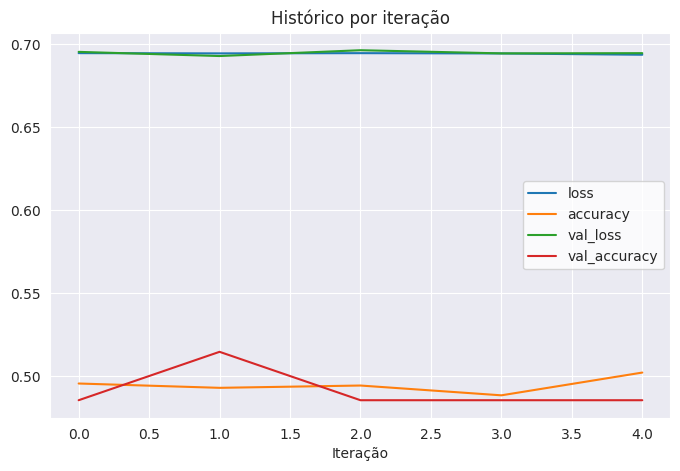

In [37]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 3s 49ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       741
           1       0.49      1.00      0.65       699

    accuracy                           0.49      1440
   macro avg       0.24      0.50      0.33      1440
weighted avg       0.24      0.49      0.32      1440



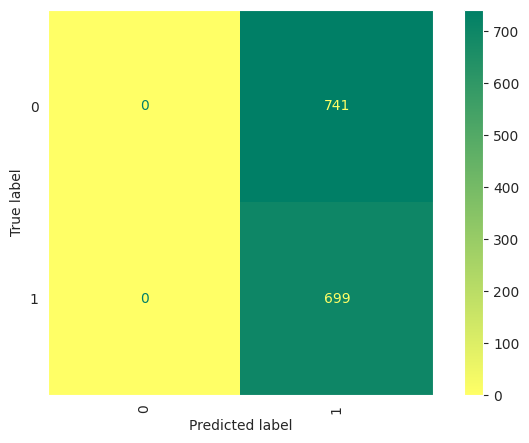

In [38]:
dados_modelo(modelo_numero)

In [39]:
relatorios[modelo_numero]

{'acuracia': 0.48541666666666666,
 'precisao': 0.23562934027777777,
 'revocacao': 0.48541666666666666,
 'pontuacao-f1': 0.31725689574567556}

### Modelo 4: LSTM Bidirecional

In [40]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_lstm_bidirecional'

# camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN, return_sequences=True))(camadas_iniciais)
# camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas)
camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 48s 469ms/step - loss: 0.4369 - accuracy: 0.8090 - val_loss: 0.1822 - val_accuracy: 0.9507
Epoch 2/5
90/90 [==============================] - 41s 461ms/step - loss: 0.1617 - accuracy: 0.9509 - val_loss: 0.1609 - val_accuracy: 0.9507
Epoch 3/5
90/90 [==============================] - 42s 468ms/step - loss: 0.0418 - accuracy: 0.9915 - val_loss: 0.1784 - val_accuracy: 0.9458
Epoch 4/5
90/90 [==============================] - 40s 443ms/step - loss: 0.0173 - accuracy: 0.9974 - val_loss: 0.1520 - val_accuracy: 0.9549
Epoch 5/5
90/90 [==============================] - 40s 448ms/step - loss: 0.0073 - accuracy: 0.9991 - val_loss: 0.1678 - val_accuracy: 0.9590
CPU times: user 3min 12s, sys: 5 s, total: 3min 17s
Wall time: 3min 31s


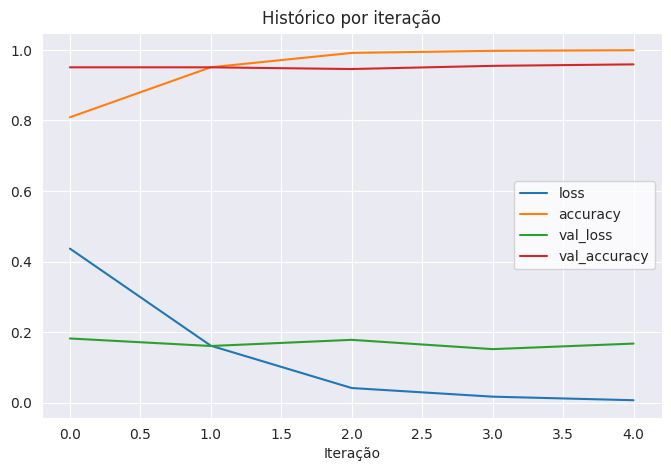

In [41]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 5s 101ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       741
           1       0.97      0.95      0.96       699

    accuracy                           0.96      1440
   macro avg       0.96      0.96      0.96      1440
weighted avg       0.96      0.96      0.96      1440



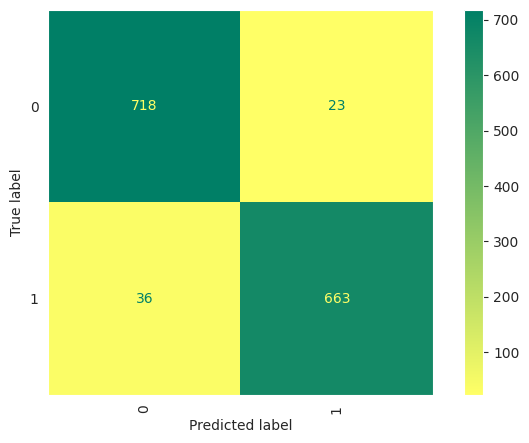

In [42]:
dados_modelo(modelo_numero)

In [43]:
relatorios[modelo_numero]

{'acuracia': 0.9590277777777778,
 'precisao': 0.9591561316644885,
 'revocacao': 0.9590277777777778,
 'pontuacao-f1': 0.9590136294668551}

### Modelo 5: GRU Bidirecional

In [44]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_gru_bidirecional'

# camadas = Bidirectional(layer=GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN, return_sequences=True))(camadas_iniciais)
# camadas = Bidirectional(layer=GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas)
camadas = Bidirectional(layer=GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 47s 463ms/step - loss: 0.2637 - accuracy: 0.8960 - val_loss: 0.2771 - val_accuracy: 0.9264
Epoch 2/5
90/90 [==============================] - 41s 454ms/step - loss: 0.0855 - accuracy: 0.9802 - val_loss: 0.3540 - val_accuracy: 0.8819
Epoch 3/5
90/90 [==============================] - 40s 441ms/step - loss: 0.0865 - accuracy: 0.9740 - val_loss: 0.3210 - val_accuracy: 0.9146
Epoch 4/5
90/90 [==============================] - 39s 429ms/step - loss: 0.0337 - accuracy: 0.9903 - val_loss: 0.2844 - val_accuracy: 0.9319
Epoch 5/5
90/90 [==============================] - 37s 417ms/step - loss: 0.0157 - accuracy: 0.9960 - val_loss: 0.2835 - val_accuracy: 0.9292
CPU times: user 3min 8s, sys: 3.24 s, total: 3min 12s
Wall time: 3min 23s


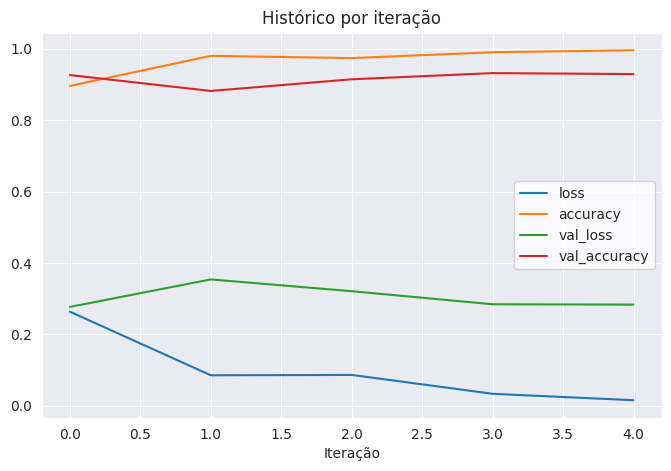

In [45]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 6s 109ms/step
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       741
           1       0.90      0.96      0.93       699

    accuracy                           0.93      1440
   macro avg       0.93      0.93      0.93      1440
weighted avg       0.93      0.93      0.93      1440



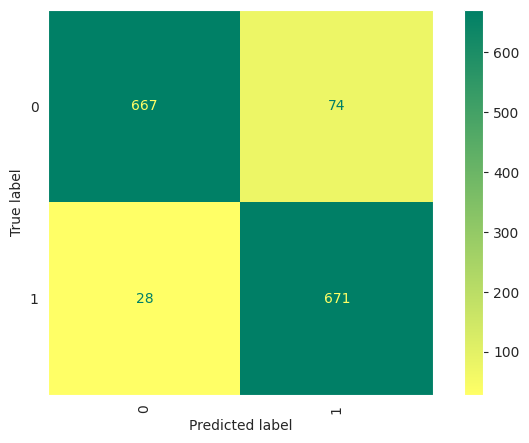

In [46]:
dados_modelo(modelo_numero)

In [47]:
relatorios[modelo_numero]

{'acuracia': 0.9291666666666667,
 'precisao': 0.9310527014629906,
 'revocacao': 0.9291666666666667,
 'pontuacao-f1': 0.929160381252942}

### Modelo 6: CNN

In [48]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_cnn'

camadas = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=NUCLEO_TAMANHO,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas_iniciais)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 34s 266ms/step - loss: 0.0948 - accuracy: 0.9731 - val_loss: 0.1678 - val_accuracy: 0.9368
Epoch 2/5
90/90 [==============================] - 23s 250ms/step - loss: 0.0062 - accuracy: 0.9991 - val_loss: 0.1885 - val_accuracy: 0.9361
Epoch 3/5
90/90 [==============================] - 22s 245ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.2123 - val_accuracy: 0.9312
Epoch 4/5
90/90 [==============================] - 22s 240ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.2227 - val_accuracy: 0.9299
Epoch 5/5
90/90 [==============================] - 21s 229ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.2242 - val_accuracy: 0.9326
CPU times: user 1min 35s, sys: 2.29 s, total: 1min 38s
Wall time: 2min 22s


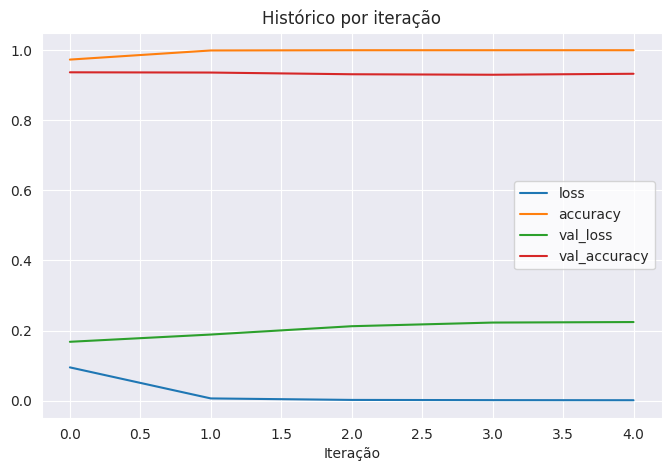

In [49]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       741
           1       0.90      0.97      0.93       699

    accuracy                           0.93      1440
   macro avg       0.93      0.93      0.93      1440
weighted avg       0.94      0.93      0.93      1440



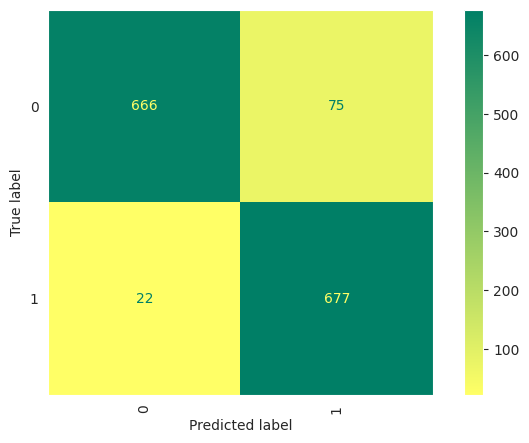

In [50]:
dados_modelo(modelo_numero)

In [51]:
relatorios[modelo_numero]

{'acuracia': 0.9326388888888889,
 'precisao': 0.9351327338982351,
 'revocacao': 0.9326388888888889,
 'pontuacao-f1': 0.9326199489682157}

### Modelo 7: TFHub Universal Sentence Encoder

Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

In [52]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_tfhub_use'

modelos[modelo_numero] = Sequential(name=modelo_nome)

modelos[modelo_numero].add(hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                                          trainable=False,
                                          input_shape=[], # USE aceita textos de tamanho variável.
                                          dtype=ENTRADA_TIPO,
                                          name='camada_use'))

modelos[modelo_numero].add(Dense(ESPACO_SAIDA*2, activation=ATIVACAO_CNN, name='camada_relu'))
modelos[modelo_numero].add(Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida'))

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 23s 204ms/step - loss: 0.3046 - accuracy: 0.9177 - val_loss: 0.1727 - val_accuracy: 0.9354
Epoch 2/5
90/90 [==============================] - 15s 168ms/step - loss: 0.1713 - accuracy: 0.9391 - val_loss: 0.1638 - val_accuracy: 0.9361
Epoch 3/5
90/90 [==============================] - 15s 169ms/step - loss: 0.1629 - accuracy: 0.9429 - val_loss: 0.1582 - val_accuracy: 0.9396
Epoch 4/5
90/90 [==============================] - 15s 170ms/step - loss: 0.1568 - accuracy: 0.9450 - val_loss: 0.1535 - val_accuracy: 0.9410
Epoch 5/5
90/90 [==============================] - 19s 212ms/step - loss: 0.1525 - accuracy: 0.9460 - val_loss: 0.1497 - val_accuracy: 0.9417
CPU times: user 1min 43s, sys: 4.44 s, total: 1min 47s
Wall time: 2min 54s


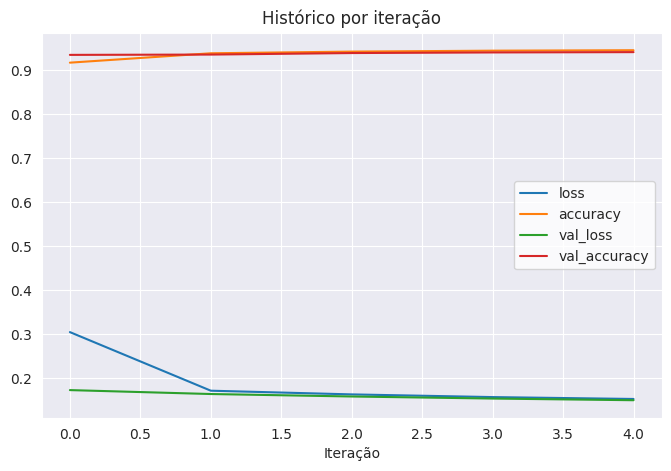

In [53]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 3s 59ms/step
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       741
           1       0.95      0.93      0.94       699

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.94      0.94      0.94      1440



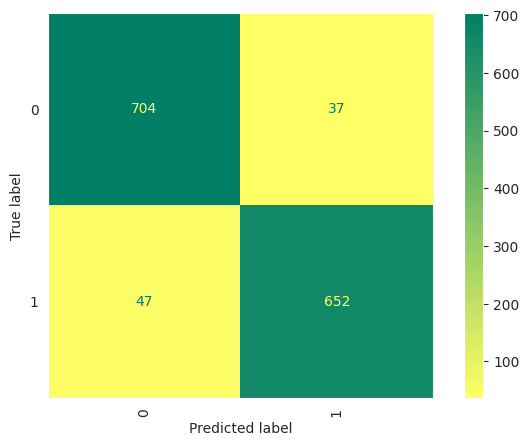

In [54]:
dados_modelo(modelo_numero)

In [55]:
relatorios[modelo_numero]

{'acuracia': 0.9416666666666667,
 'precisao': 0.9417283486555903,
 'revocacao': 0.9416666666666667,
 'pontuacao-f1': 0.9416520192225974}

### Modelo 8: DCNN

In [56]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_dcnn'

# Bigram

bigram = Conv1D(filters=ESPACO_SAIDA,
                kernel_size=2,
                activation=ATIVACAO_CNN,
                padding=PREENCHIMENTO,
                name='camada_bigram')(camadas_iniciais)

bigram = GlobalMaxPool1D(name='agrupamento_maximo_bigram')(bigram)

# Trigram

trigram = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=3,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_trigram')(camadas_iniciais)

trigram = GlobalMaxPool1D(name='agrupamento_maximo_trigram')(trigram)

# Fourgram

fourgram = Conv1D(filters=ESPACO_SAIDA,
                  kernel_size=4,
                  activation=ATIVACAO_CNN,
                  padding=PREENCHIMENTO,
                  name='camada_fourgram')(camadas_iniciais)

fourgram = GlobalMaxPool1D(name='agrupamento_maximo_fourgram')(fourgram)

# Concatenação dos ngrams

# camadas = tf.concat([bigram, trigram, fourgram], axis=-1)
camadas = Concatenate(name="camada_concatenacao")([bigram, trigram, fourgram])

# Camada densa

camadas = Dense(units=512, activation=ATIVACAO_CNN, name='camada_densa')(camadas)

# Camada de abandono

camadas = Dropout(rate=ABANDONOS, name='camada_abandono')(camadas)

# Camada de saída

saidas = Dense(units=1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 29s 280ms/step - loss: 0.2098 - accuracy: 0.9385 - val_loss: 0.1475 - val_accuracy: 0.9486
Epoch 2/5
90/90 [==============================] - 24s 265ms/step - loss: 0.0324 - accuracy: 0.9901 - val_loss: 0.1437 - val_accuracy: 0.9549
Epoch 3/5
90/90 [==============================] - 22s 239ms/step - loss: 0.0044 - accuracy: 0.9995 - val_loss: 0.1512 - val_accuracy: 0.9549
Epoch 4/5
90/90 [==============================] - 23s 250ms/step - loss: 8.1222e-04 - accuracy: 1.0000 - val_loss: 0.1632 - val_accuracy: 0.9535
Epoch 5/5
90/90 [==============================] - 21s 239ms/step - loss: 4.1557e-04 - accuracy: 1.0000 - val_loss: 0.1693 - val_accuracy: 0.9528
CPU times: user 1min 33s, sys: 1.77 s, total: 1min 35s
Wall time: 2min 23s


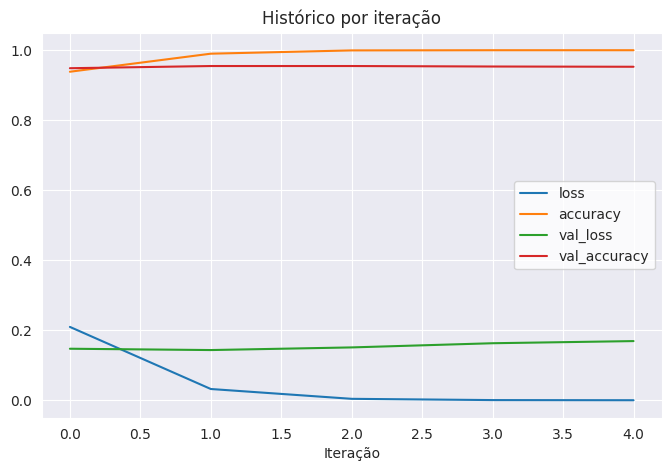

In [57]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       741
           1       0.94      0.97      0.95       699

    accuracy                           0.95      1440
   macro avg       0.95      0.95      0.95      1440
weighted avg       0.95      0.95      0.95      1440



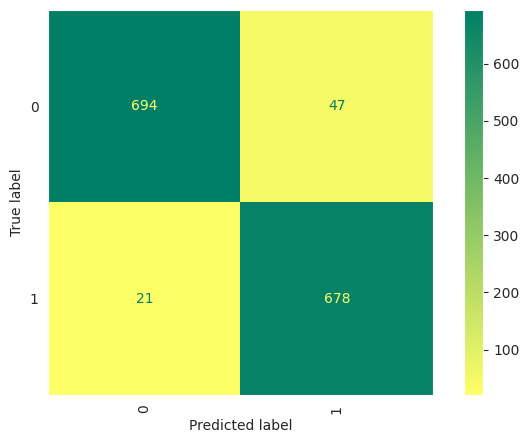

In [58]:
dados_modelo(modelo_numero)

In [59]:
relatorios[modelo_numero]

{'acuracia': 0.9527777777777777,
 'precisao': 0.953417972831766,
 'revocacao': 0.9527777777777777,
 'pontuacao-f1': 0.9527872525414659}

## Comparar modelos

In [60]:
comparacao = pd.DataFrame([r for r in relatorios if r is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

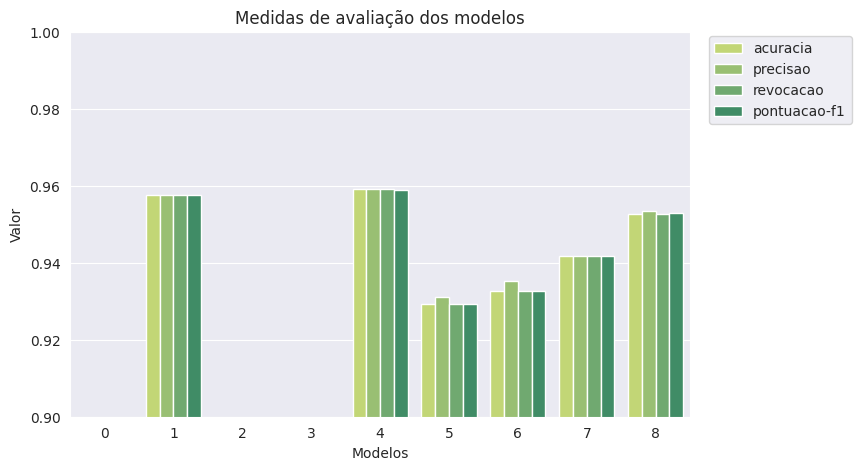

In [61]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.9, 1.0)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelos')
plt.ylabel('Valor')

plt.legend(loc=(1.03, 0.76));